In [1]:
!nvidia-smi

Wed Mar  2 06:14:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   45C    P0    37W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

## 導入模塊

In [2]:
import os
import glob
import torch 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.io import read_image
from preprocess_and_augmentation import RoadDataset, Train_Augmentation, Test_Augmentation
import losses_and_metrics as lm 
import resnet50_unet_dropblock
from trainer import Trainer
from semantic_segmentation_test import Inference_Pipeline 

## 基本配置

In [4]:
H, W = 448, 512 
train_ratio = 0.8
test_ratio = 0.1
batch_size = 48
n_classes = 6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# image, label directory
img_dir = "./resize_img_448_512/images/"
label_dir = "./resize_img_448_512/labels/"

# save path
filename = "semantic_segmentation_v15.pth"
dst_path = os.path.join("./models", filename)

In [5]:
# basic functions
def image_to_label(path): 
    return os.path.join(label_dir, os.path.basename(path).split(".")[0] + "_lane_line_label_id.png")

def tensor_to_img(x): 
    return torch.permute(x, dims=[1, 2, 0]).squeeze().numpy()

## Dataset, Dataloader

In [6]:
img_list = os.listdir(img_dir)
img_list.sort()
np.random.shuffle(img_list)

train_img_list = img_list[:int(len(img_list)*train_ratio)]
test_img_list = img_list[int(len(img_list)*train_ratio):int(len(img_list)*(train_ratio + test_ratio))]

In [7]:
train_dataset = RoadDataset(img_dir, image_to_label, image_transform=None, filter_list=train_img_list)
test_dataset = RoadDataset(img_dir, image_to_label, image_transform=None, filter_list=test_img_list)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# test output of dataloader
x = next(iter(train_dataloader))

print(x[0].shape, x[0].dtype)
print(x[1].shape, x[1].dtype)

torch.Size([48, 3, 448, 512]) torch.uint8
torch.Size([48, 1, 448, 512]) torch.int64


## Data Augmentation

In [10]:
train_aug = Train_Augmentation(img_size=(H, W), normalize=True)
test_aug = Test_Augmentation(img_size=(H, W), normalize=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([48, 3, 448, 512]) torch.Size([48, 6, 448, 512])


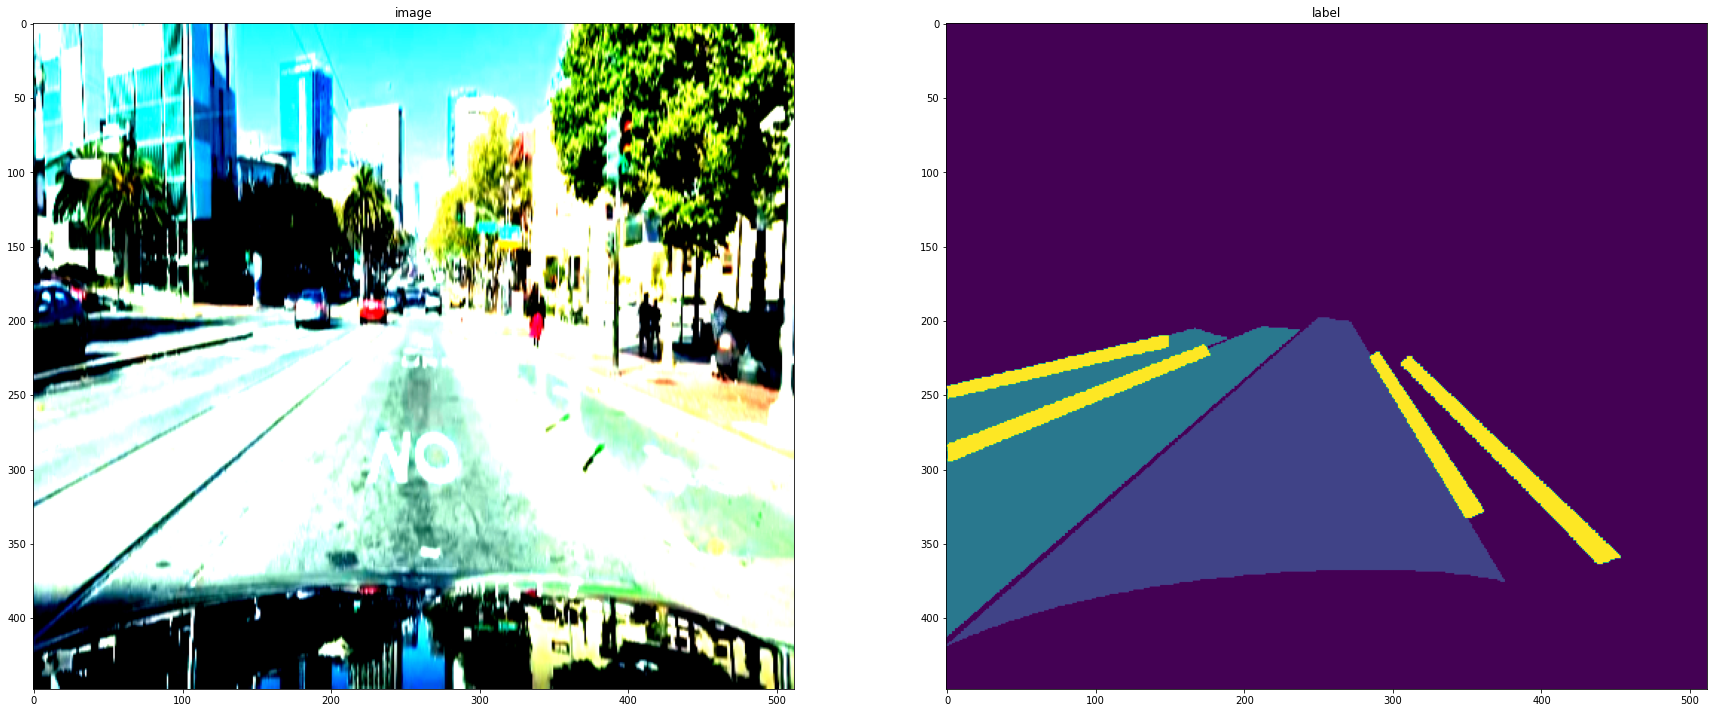

In [12]:
# show augmentation result 
data, targets = next(iter(train_dataloader))
data, targets = train_aug(data, targets)

print(data.shape, targets.shape)

index = 1
f, axarr = plt.subplots(1, 2, figsize=(30, 30))

axarr[0].imshow(tensor_to_img(data[index]))
axarr[1].imshow(targets[index].argmax(dim=0).numpy()/6)
axarr[0].set_title("image")
axarr[1].set_title("label")
plt.show()

## 訓練

In [13]:
# build model
model = resnet50_unet_dropblock.UNetWithResnet50Encoder(n_classes=6, 
                                                        bridge="spatial_attn", 
                                                        drop_prob=0.2, 
                                                        block_size=5)
model= nn.DataParallel(model)
model.to(device=DEVICE)

DataParallel(
  (module): UNetWithResnet50Encoder(
    (input_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
# training cofig

decay_fn = lambda n: 1 if n <=15 else 0.2 
num_epoch = 20
loss_fn = lm.BceDiceLoss() 
# lm.GDiceLossV2(nn.Softmax(dim=1), do_bg=False, smooth=1e-5)
# lm.IoULoss(nn.Softmax(dim=1), batch_dice=True, do_bg=False, smooth=1e-6, square=True)
# lm.SoftDiceLoss(nn.Softmax(dim=1), batch_dice=True, do_bg=False, smooth=1e-6, square=True)
# lm.BceLoss()
# lm.BceDiceLoss()

metric_dict = {
    "Accuracy": lm.Accuracy(), 
    "miou": lm.IoULoss(nn.Softmax(dim=1), batch_dice=True, do_bg=False, square=False),
    "BceDice": loss_fn
}

save_config = {
    "path": dst_path, 
    "freq": 1
}

In [15]:
%%time
train_pipeline = Trainer()
train_pipeline.compile(train_aug, test_aug, 1e-4, decay_fn, loss_fn, metric_dict, DEVICE)
train_pipeline.fit(model, train_dataloader, test_dataloader, num_epoch, save_config)

100%|██████████| 592/592 [09:50<00:00,  1.00it/s, loss=0.567]


train_loss: 0.9860159382853709
{'Accuracy': 0.9470970630645752, 'miou': 0.7145751714706421, 'BceDice': 0.520898699760437}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.35] 


train_loss: 0.40912415146827696
{'Accuracy': 0.9572117328643799, 'miou': 0.5904910564422607, 'BceDice': 0.3635299503803253}


100%|██████████| 592/592 [09:43<00:00,  1.01it/s, loss=0.361]


train_loss: 0.32839549703497284
{'Accuracy': 0.9589398503303528, 'miou': 0.5122503042221069, 'BceDice': 0.32498782873153687}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.348]


train_loss: 0.29848914799555926
{'Accuracy': 0.9598429799079895, 'miou': 0.4745387136936188, 'BceDice': 0.308724582195282}


100%|██████████| 592/592 [09:43<00:00,  1.02it/s, loss=0.263]


train_loss: 0.2776440261619192
{'Accuracy': 0.959625780582428, 'miou': 0.4493713974952698, 'BceDice': 0.31031516194343567}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.233]


train_loss: 0.26311957099068334
{'Accuracy': 0.960015594959259, 'miou': 0.4339350461959839, 'BceDice': 0.3057968020439148}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.218]


train_loss: 0.2502053869442201
{'Accuracy': 0.9614120125770569, 'miou': 0.41753089427948, 'BceDice': 0.2956389784812927}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.291]


train_loss: 0.2409316560248254
{'Accuracy': 0.9603738784790039, 'miou': 0.4118548333644867, 'BceDice': 0.2990029454231262}


100%|██████████| 592/592 [09:43<00:00,  1.01it/s, loss=0.243]


train_loss: 0.23264495957905137
{'Accuracy': 0.962216317653656, 'miou': 0.4032784402370453, 'BceDice': 0.2894320487976074}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.245]


train_loss: 0.22403037163573253
{'Accuracy': 0.9607011675834656, 'miou': 0.39684829115867615, 'BceDice': 0.2908923923969269}


100%|██████████| 592/592 [09:45<00:00,  1.01it/s, loss=0.185]


train_loss: 0.21808054574778382
{'Accuracy': 0.9616427421569824, 'miou': 0.3800711929798126, 'BceDice': 0.2946455180644989}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.164]


train_loss: 0.21180475278639457
{'Accuracy': 0.9610891342163086, 'miou': 0.38896000385284424, 'BceDice': 0.2978995144367218}


100%|██████████| 592/592 [09:43<00:00,  1.01it/s, loss=0.184]


train_loss: 0.2041419462838643
{'Accuracy': 0.9619727730751038, 'miou': 0.3796888291835785, 'BceDice': 0.2897653877735138}


100%|██████████| 592/592 [09:45<00:00,  1.01it/s, loss=0.176]


train_loss: 0.20000937989060308
{'Accuracy': 0.9617173671722412, 'miou': 0.38030362129211426, 'BceDice': 0.29692426323890686}


100%|██████████| 592/592 [09:46<00:00,  1.01it/s, loss=0.192]


train_loss: 0.19533649102063247
{'Accuracy': 0.9617176055908203, 'miou': 0.37302494049072266, 'BceDice': 0.2958499789237976}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.17] 


train_loss: 0.19223061823509108
{'Accuracy': 0.9624738693237305, 'miou': 0.36305806040763855, 'BceDice': 0.29032832384109497}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.147]


train_loss: 0.1654032528862147
{'Accuracy': 0.9644936919212341, 'miou': 0.3482154905796051, 'BceDice': 0.2796574532985687}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.14] 


train_loss: 0.15753897352537638
{'Accuracy': 0.9642287492752075, 'miou': 0.3479722738265991, 'BceDice': 0.28226953744888306}


100%|██████████| 592/592 [09:43<00:00,  1.01it/s, loss=0.156]


train_loss: 0.1524041099993276
{'Accuracy': 0.9636797904968262, 'miou': 0.3523702919483185, 'BceDice': 0.28936833143234253}


100%|██████████| 592/592 [09:44<00:00,  1.01it/s, loss=0.155]


train_loss: 0.14958526189898103
{'Accuracy': 0.9641700387001038, 'miou': 0.34885135293006897, 'BceDice': 0.288985013961792}
CPU times: user 10h 39min 32s, sys: 3h 24min 53s, total: 14h 4min 26s
Wall time: 3h 34min 6s


## 測試

In [17]:
# test config

H, W = 448, 512
color_dict = color_dict = {
    0: [0, 0, 0], 
    1: [0, 255, 0], 
    2: [255, 0, 0], 
    3: [0, 255, 255], 
    4: [255, 255, 0], 
    5: [0, 0, 255]
}

test_tool = Inference_Pipeline(model, (H, W), test_aug)

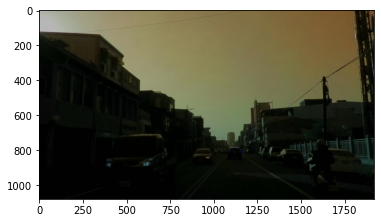

/home/ubuntu/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(1080, 1920, 3)


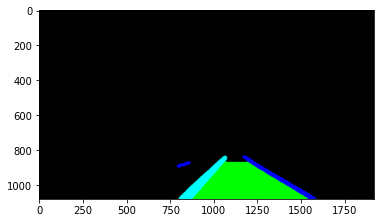

In [50]:
path = "./demo/0403.jpg"

plt.imshow(cv2.imread(path))
plt.show()

batch = read_image(path).unsqueeze(dim=0)
output = test_tool.predict(batch).squeeze().cpu().numpy()
output = np.stack((output, )*3, axis=2)
output = test_tool.class_to_color(output, color_dict)

print(output.shape)
plt.imshow(output.astype(np.uint8))
plt.show()